# Preparing Hyperspectral Data for Different Satellites 🛰

Welcome to this code notebook on preparing hyperspectral data for use with different satellite sensors! 🛰️

Here we will take a CSV containing hyperspectral data with n channels, and convert it into datasets containing only the specific channels available on various satellites. This allows the rich hyperspectral data to be usable with multispectral sensors. 

### Overview:

- Import hyperspectral CSV
- Define helper functions for each satellite
    - Sentinel-2
    - Landsat 8
    - Venus 
    - Planet
    - etc
- Apply function to downsample data to match satellite  
- Export new CSV for each satellite

This enables easy preprocessing of hyperspectral data to fit the channels of various satellites. By averaging wavelengths, we can squeeze high dimensionality data into the bands available commercially. 📉

The helper functions will handle the wavelength math, converting 205 bands down to just the ones needed. This makes it fast and simple to reformat data for a target satellite. 

Some examples and visualizations will show the process in action. We'll go step-by-step from the raw hyperspectral data to the final formatted CSVs.

Let's get started! First we'll import our libraries and data.

*Any feedback welcome!* 😊 

Contact: [yehudayu@gmail.com](mailto:yehudayu@gmail.com)

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# Load data
def load_data(csv_path, feature_col_start, feature_col_end, target_col):
    """
    Load a CSV file into a Pandas DataFrame and separate the feature and target columns.

    Parameters:
        csv_path (str): Path to the CSV file to load.
        feature_col_start, feature_col_end, (ints): Range of column indices to use as features.
        target_col (str or int): Name or index of the column to use as target.

    Returns:
        new_df: A df containing the features + labels DataFrame.
    """
    # Load CSV into a Pandas DataFrame
    df = pd.read_csv(csv_path)

    # Extract the feature and target columns
    new_df = df[df.columns[feature_col_start: feature_col_end]]
    new_df[target_col] = df[target_col]

    # drop nan values
    new_df = new_df.dropna()

    return new_df

Function to Sentinel-2

In [41]:
def aggregate_sentinel_bands(df, cols,target_col):
    """
    Aggregate Sentinel-2 spectral bands in a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing spectral band columns.
        cols (list): List of column names to be converted to string and used for aggregation.

    Returns:
        pandas.DataFrame: A new DataFrame with aggregated spectral bands as columns.
    """
    
    # Convert specified column names to strings
    df.rename(columns={col: str(col) for col in cols}, inplace=True)

    # Define the wavelength ranges of each band in nanometers (nm)
    sentinel_bands = [
        (443, 490),   # Band 1 (Coastal aerosol)
        (490, 560),   # Band 2 (Blue)
        (560, 665),   # Band 3 (Green)
        (665, 705),   # Band 4 (Red)
        (705, 740),   # Band 5 (Vegetation Red Edge)
        (740, 783),   # Band 6 (Vegetation Red Edge)
        (783, 842),   # Band 7 (Vegetation Red Edge)
        (842, 865),   # Band 8 (Near Infrared)
        (865, 945),   # Band 8A (Narrow Near Infrared)
        (945, 1375),  # Band 9 (Water vapor)
        (1375, 1610), # Band 10 (Cirrus)
        (1610, 2190), # Band 11 (Short Wave Infrared)
        (2190, 2200)  # Band 12 (Short Wave Infrared)
    ]

    sentinel_bands_dict = {band: [] for band in sentinel_bands}

    # Loop through the columns in the DataFrame and append the column name to the list of the corresponding key
    for col in cols:
        col_num = int(col)
        for band in sentinel_bands:
            if band[0] <= col_num < band[1]:
                sentinel_bands_dict[band].append(col)

    # Create a new DataFrame for all the columns that have the same value to produce one average column of all these columns
    sentinel_df = pd.DataFrame()
    for band, band_cols in sentinel_bands_dict.items():
        if len(band_cols) > 0:
            new_col_name = f'{band[0]}-{band[1]}'
            sentinel_df[new_col_name] = df[band_cols].mean(axis=1)
    
    # add target column
    sentinel_df[target_col] = df[target_col].values

    return sentinel_df

In [53]:
def aggregate_planet_bands(df, cols,target_col):
    """
    Aggregate PlanetScope spectral bands in a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing spectral band columns.
        cols (list): List of column names to be converted to string and used for aggregation.

    Returns:"
        pandas.DataFrame: A new DataFrame with aggregated spectral bands as columns.
    
    """
    # Convert specified column names to strings
    df.rename(columns={col: str(col) for col in cols}, inplace=True)

    # Define planet bands
    planet_bands = [
        (443, 20),   # Band 1
        (490, 50),   # Band 2
        (531, 36),   # Band 3
        (565, 36),   # Band 4
        (610, 20),   # Band 5
        (665, 31),   # Band 6
        (705, 15),   # Band 7
        (865, 40),   # Band 8
        ]

    planet_bands_dict = {}

    # Calculate minimum and maximum wavelength values for each band
    for band in planet_bands:
        wavelength, bandwidth = band
        min_wavelength = wavelength - (bandwidth / 2)
        max_wavelength = wavelength + (bandwidth / 2)
        new_band = (int(min_wavelength), int(max_wavelength))
        planet_bands_dict[new_band] = []

    # Loop through the columns in the DataFrame and append the column name to the list of the corresponding key
    for col in cols:
        col_num = int(col)
        for band in planet_bands_dict.keys():
            if band[0] <= col_num < band[1]:
                planet_bands_dict[band].append(col)
    
    # Create a new DataFrame for all the columns that have the same value to produce one average column of all these columns
    planet_df = pd.DataFrame()
    for band, band_cols in planet_bands_dict.items():
        if len(band_cols) > 0:
            new_col_name = f'{band[0]}-{band[1]}'
            planet_df[new_col_name] = df[band_cols].mean(axis=1)

    # add target column
    planet_df[target_col] = df[target_col].values

    return planet_df

In [61]:
def aggregate_modis_bands(df, cols,target_col):
    """
    Aggregate MODIS spectral bands in a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing spectral band columns.
        cols (list): List of column names to be converted to string and used for aggregation.

    Returns:"
        pandas.DataFrame: A new DataFrame with aggregated spectral bands as columns.
    
    """

    # Convert specified column names to strings
    df.rename(columns={col: str(col) for col in cols}, inplace=True)

    # Define modis bands
    modis_bands = [
        (405, 420),
        (438, 448),
        (438, 493),
        (459, 479),
        (526, 536),
        (545, 565),
        (546, 556),
        (620, 670),
        (662, 672),
        (673, 683),
        (743, 753),
        (841, 876),
        (862, 877),
        (890, 920),
        (915, 965),
        (931, 941),
        (1230, 1250),
        (1628, 1652),
        (2105, 2155)]

    modis_bands_dict = {band: [] for band in modis_bands}

    # Loop through the columns in the DataFrame and append the column name to the list of the corresponding key
    for col in cols:
        col_num = int(col)
        for band in modis_bands:
            if band[0] <= col_num < band[1]:
                modis_bands_dict[band].append(col)

    # Create a new DataFrame for all the columns that have the same value to produce one average column of all these columns
    modis_df = pd.DataFrame()
    for band, band_cols in modis_bands_dict.items():
        if len(band_cols) > 0:
            new_col_name = f'{band[0]}-{band[1]}'
            modis_df[new_col_name] = df[band_cols].mean(axis=1)

    # add target column
    modis_df[target_col] = df[target_col].values

    return modis_df


In [65]:
def aggregate_landsat_bands(df, cols,target_col):
    """
    Aggregate Landsat 8 spectral bands in a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing spectral band columns.
        cols (list): List of column names to be converted to string and used for aggregation.
        target_col (str or int): Name or index of the column to use as target.

    Returns:
        pandas.DataFrame: A new DataFrame with aggregated spectral bands as columns.

    """
    # Convert specified column names to strings
    df.rename(columns={col: str(col) for col in cols}, inplace=True)

    landsat_bands = [
        (433,453),   # Band1
        (450,515),   # Band2
        (525,600),   # Band3
        (630,680),   # Band4
        (845,885),   # Band5
        (1560,1660), # Band6
        (2100,2300), # Band7
        (500,680),   # Band8
        (1360,1390), # Band9
        (10600,11200),#Band10
        (11500,12500)#Band11
    ]

    landsat_bands_dict = {band: [] for band in landsat_bands}

    # Loop through the columns in the DataFrame and append the column name to the list of the corresponding key
    for col in cols:
        col_num = int(col)
        for band in landsat_bands:
            if band[0] <= col_num < band[1]:
                landsat_bands_dict[band].append(col)

    # Create a new DataFrame for all the columns that have the same value to produce one average column of all these columns
    landsat_df = pd.DataFrame()
    for band, band_cols in landsat_bands_dict.items():
        if len(band_cols) > 0:
            new_col_name = f'{band[0]}-{band[1]}'
            landsat_df[new_col_name] = df[band_cols].mean(axis=1)

    # add target column 
    landsat_df[target_col] = df[target_col].values

    return landsat_df


## Example

In [54]:
# Define input parameters
csv_path = r"G:\My Drive\LWP_Netanel\Sg_clean_data.csv" # input your CSV file path
# first index of feature column
feature_idx_i = 5
# last index of feature column
feature_idx_f = -4
# target column name
target_col = 'LWP'

# Load data
df = load_data(csv_path, feature_idx_i,feature_idx_f, target_col)
df.head()

<ipython-input-8-c7495d500215>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[target_col] = df[target_col]


,409,411,413,415,417,420,422,424,426,429,...,984,986,988,990,993,995,997,999,1001,LWP
0,0.032257,0.028898,0.026011,0.023595,0.021651,0.019818,0.019893,0.019976,0.019795,0.020430,...,0.216616,0.217647,0.219013,0.220716,0.222754,0.225129,0.227839,0.230886,0.234268,-1.15
1,0.032840,0.029338,0.026278,0.023660,0.021485,0.019600,0.018930,0.019090,0.018814,0.018739,...,0.318814,0.320154,0.321991,0.324323,0.327153,0.330478,0.334300,0.338619,0.343433,-2.75
2,0.035203,0.031768,0.028759,0.026176,0.024018,0.022017,0.021255,0.021318,0.020964,0.020824,...,0.264970,0.265995,0.267401,0.269188,0.271355,0.273903,0.276832,0.280141,0.283831,-2.35
3,0.010661,0.008955,0.007468,0.006198,0.005145,0.004496,0.004427,0.004435,0.004389,0.004254,...,0.026592,0.026661,0.026748,0.026854,0.026978,0.027121,0.027282,0.027462,0.027660,-2.30
4,0.033712,0.030417,0.027554,0.025125,0.023129,0.021416,0.020777,0.020932,0.020762,0.020907,...,0.250645,0.251760,0.253260,0.255145,0.257415,0.260070,0.263109,0.266533,0.270341,-1.62


In [44]:
df_sentinel = aggregate_sentinel_bands(df= df, cols= df.columns[:-1], target_col= target_col)
df_sentinel.head()

,443-490,490-560,560-665,665-705,705-740,740-783,783-842,842-865,865-945,945-1375,LWP
0,0.033770,0.048394,0.051638,0.043978,0.133212,0.215064,0.227694,0.231635,0.230752,0.222268,-1.15
1,0.023448,0.037766,0.038601,0.033794,0.154233,0.292397,0.317441,0.326392,0.336126,0.327832,-2.75
2,0.025672,0.039248,0.042898,0.039348,0.145664,0.241319,0.258853,0.266343,0.274011,0.271520,-2.35
3,0.004527,0.006518,0.006959,0.006134,0.016626,0.025567,0.026825,0.027377,0.026936,0.026776,-2.30
4,0.031914,0.046314,0.048988,0.041653,0.139572,0.236297,0.253912,0.259701,0.264872,0.257357,-1.62


In [55]:
df_planet = aggregate_planet_bands(df= df, cols= df.columns[:-1], target_col= target_col)
df_planet.head()

,433-453,465-515,513-549,547-583,600-620,649-680,697-712,845-885,LWP
0,0.026620,0.037062,0.050732,0.059942,0.052178,0.040328,0.072864,0.232679,-1.15
1,0.021315,0.024635,0.040879,0.049703,0.038052,0.028555,0.067227,0.329591,-2.75
2,0.023395,0.026948,0.041842,0.052003,0.042569,0.033973,0.072713,0.268808,-2.35
3,0.004414,0.004709,0.006955,0.008213,0.006934,0.005634,0.009759,0.027516,-2.30
4,0.025726,0.034648,0.048766,0.058241,0.049232,0.037944,0.071162,0.261868,-1.62


In [62]:
df_modis = aggregate_modis_bands(df= df, cols= df.columns[:-1], target_col= target_col)
df_modis.head()


,405-420,438-448,438-493,459-479,526-536,545-565,546-556,620-670,662-672,673-683,743-753,841-876,862-877,890-920,915-965,931-941,LWP
0,0.026482,0.027201,0.033248,0.034890,0.050965,0.060723,0.060206,0.045625,0.039603,0.036573,0.205152,0.231832,0.231936,0.232923,0.225428,0.223891,-1.15
1,0.026720,0.021612,0.023277,0.023764,0.041471,0.051964,0.051883,0.032627,0.027951,0.026144,0.273786,0.327533,0.329338,0.338144,0.334943,0.336445,-2.75
2,0.029185,0.023677,0.025496,0.025996,0.042086,0.053481,0.053039,0.037682,0.033410,0.031508,0.229491,0.267202,0.268521,0.275698,0.274345,0.274150,-2.35
3,0.007685,0.004444,0.004522,0.004535,0.007051,0.008410,0.008373,0.006200,0.005524,0.005180,0.024775,0.027441,0.027506,0.026861,0.026582,0.026400,-2.30
4,0.027987,0.026193,0.031452,0.032945,0.049069,0.059408,0.058976,0.042861,0.037215,0.034576,0.225080,0.260428,0.261534,0.265968,0.262601,0.264183,-1.62


In [66]:
df_landsat = aggregate_landsat_bands(df= df, cols= df.columns[:-1], target_col= target_col)
df_landsat.head()

,433-453,450-515,525-600,630-680,845-885,500-680,LWP
0,0.026620,0.036005,0.057024,0.043112,0.232679,0.050067,-1.15
1,0.021315,0.024325,0.046337,0.030729,0.329591,0.038147,-2.75
2,0.023395,0.026596,0.048562,0.035954,0.268808,0.041544,-2.35
3,0.004414,0.004655,0.007798,0.005934,0.027516,0.006785,-2.30
4,0.025726,0.033775,0.055079,0.040531,0.261868,0.047676,-1.62


Let show the difference between the original hyperspectral data and the downsampled data for Sentinel-2.

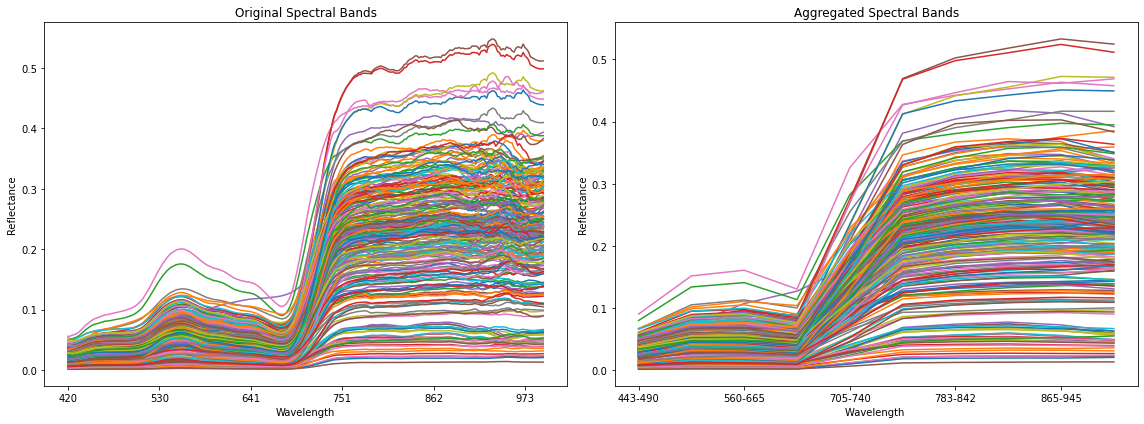

In [52]:
# Plot original and aggregated spectral bands in 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot original spectral bands
df[df.columns[feature_idx_i:feature_idx_f]].T.plot(ax=axes[0], legend=False)
axes[0].set_title('Original Spectral Bands')

# Plot aggregated spectral bands
df_sentinel[df_sentinel.columns[:-1]].T.plot(ax=axes[1], legend=False)
axes[1].set_title('Aggregated Spectral Bands')

# Add labels to the subplots
axes[0].set_xlabel('Wavelength')
axes[0].set_ylabel('Reflectance')
axes[1].set_xlabel('Wavelength ')
axes[1].set_ylabel('Reflectance')

plt.tight_layout()
plt.show()